In [1]:
import os
import requests
import aiohttp
import asyncio
import nest_asyncio
import pandas as pd
import time
import scrapy
from scrapy_playwright.page import PageMethod
from bs4 import BeautifulSoup
import nest_asyncio
import glob
import numpy as np
import matplotlib.pyplot as plt


In [2]:
Fresh_Leads = pd.read_excel("Fresh_Leads_WholeSale.xlsx")
is_unique = Fresh_Leads['UEN'].is_unique
print("Is UEN unique?:", is_unique)


Is UEN unique?: True


In [3]:
# Fresh_Leads.shape

In [4]:
# count_not_nan = Fresh_Leads["Phones"].notna().sum()
# print(count_not_nan)

In [5]:

Fresh_Leads_formatted = pd.DataFrame(columns=[
    "ePOS Code",
    "Company Code",
    "Date",
    "ACRA REGISTERED NAME",
    "Brand/Deal Name/Business Name",
    "Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client",
    "Tele Sales or MR (For KPI - Internal)",
    "Name of the Market Researcher",
    "Original Source (Marketing)",
    "Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",
    "Company Registration date / Date Established",
    "Company Registration Number (UEN)",
    "Primary SSIC Code",
    "Secondary SSIC Code",
    "Hubspot ID (Company)",
    "Hubspot ID(Deal)",
    "Hubspot ID(Contact)",
    "Website URL",
    "Business Type",
    "Facebook Page",
    "Instagram URL",
    "Linkedin URL",
    "Tik Tok URL",
    "Ownership Type",
    "Parent Industry Type",
    "Industry Type",
    "Sub Industry",
    "Business model",
    "Presence of Multiple Outlets",
    "Number of Outlets (Write in #)",
    "Region",
    "Planning Area",
    "Business Location Type",
    "Registered Address (Block & Street)",
    "Registered Address  (Unit #)",
    "Registered Address  (Postal code)",
    "Operational Address \n(Block & Street)",
    "Operational Address \n(Unit #)",
    "Operational Address \n(Postal Code)",
    "Operational Address Type",
    "First Name",
    "Last Name",
    "PIC Name 1 Designation",
    "PIC NAME 1 Contact Number",
    "PIC 1 email address",
    "First Name 2",
    "Last Name 2",
    "PIC Name 2 Designation",
    "PIC NAME 2 Contact Number",
    "PIC 2 email address",
    "First Name 3",
    "Last Name 3",
    "PIC Name Designation 3",
    "PIC NAME 3 Contact Number",
    "PIC 3 email address",
    "FB/Insta/Tik Tok/Linkedin Contact",
    "Current ePOS Client ?",
    "If ePOS Client, which product they are using?",
    "Is this deal part of the Gov List?",
    "Source from Market Researcher",
    "Contact Number from Lusha?",
    "Phone number Verified ?"
])

Fresh_Leads_formatted.head()


,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?


### Fresh Leads to the Master DB format 

In [6]:
# Define the mapping from Fresh_Leads -> Fresh_Leads_formatted
cols_map = {
    "UEN": "Company Registration Number (UEN)",
    "Phones": "PIC NAME 1 Contact Number",
    "Emails": "PIC 1 email address",
    "Website": "Website URL",
    "Facebook": "Facebook Page",
    "Instagram": "Instagram URL",
    "TikTok": "Tik Tok URL",
    "LinkedIn": "Linkedin URL",
}

# Loop only over pairs where destination column ALREADY exists
for src_col, dest_col in cols_map.items():
    if src_col in Fresh_Leads.columns and dest_col in Fresh_Leads_formatted.columns:
        Fresh_Leads_formatted[dest_col] = Fresh_Leads[src_col].values
    else:
        print(f"⚠️ Skipped: {src_col} → {dest_col} (missing in one of the DataFrames)")


### ACRA DATA

In [7]:

folder_path = "Acra_Data"

# Get all CSV file paths inside the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and combine all CSVs
# Using low_memory=False to avoid DtypeWarning for mixed types
df = pd.concat((pd.read_csv(f, low_memory=False) for f in csv_files), ignore_index=True)


df.columns = df.columns.str.upper()


acra_data = df[[
    "UEN",
    "ENTITY_NAME",
    "BUSINESS_CONSTITUTION_DESCRIPTION",
    "ENTITY_TYPE_DESCRIPTION",
    "ENTITY_STATUS_DESCRIPTION",
    "REGISTRATION_INCORPORATION_DATE",
    "PRIMARY_SSIC_CODE",
    "SECONDARY_SSIC_CODE",
    "UNIT_NO",
    "LEVEL_NO",
    "BUILDING_NAME",
    "BLOCK",
    "STREET_NAME",
    "POSTAL_CODE"
]].copy()

# Convert to proper data types
# String columns
acra_data['UEN'] = acra_data['UEN'].astype('string')
acra_data['ENTITY_NAME'] = acra_data['ENTITY_NAME'].astype('string')
acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'] = acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'].astype('string')
acra_data['ENTITY_TYPE_DESCRIPTION'] = acra_data['ENTITY_TYPE_DESCRIPTION'].astype('string')
acra_data['ENTITY_STATUS_DESCRIPTION'] = acra_data['ENTITY_STATUS_DESCRIPTION'].astype('string')
acra_data['BLOCK'] = acra_data['BLOCK'].astype('string')
acra_data['STREET_NAME'] = acra_data['STREET_NAME'].astype('string')
acra_data['POSTAL_CODE'] = acra_data['POSTAL_CODE'].astype('string')
acra_data['UNIT_NO'] = acra_data['UNIT_NO'].astype('string')
acra_data['LEVEL_NO'] = acra_data['LEVEL_NO'].astype('string')
acra_data['BUILDING_NAME'] = acra_data['BUILDING_NAME'].astype('string')

# Numeric columns (SSIC codes)
acra_data['PRIMARY_SSIC_CODE'] = pd.to_numeric(acra_data['PRIMARY_SSIC_CODE'], errors='coerce')
acra_data['SECONDARY_SSIC_CODE'] = pd.to_numeric(acra_data['SECONDARY_SSIC_CODE'], errors='coerce')

# Date column
acra_data['REGISTRATION_INCORPORATION_DATE'] = pd.to_datetime(acra_data['REGISTRATION_INCORPORATION_DATE'], errors='coerce')

# Clean string columns — trim, remove extra spaces, uppercase
for col in [
    'UEN',
    'ENTITY_NAME',
    'BUSINESS_CONSTITUTION_DESCRIPTION',
    'ENTITY_TYPE_DESCRIPTION',
    'ENTITY_STATUS_DESCRIPTION',
    'BLOCK',
    'STREET_NAME',
    'POSTAL_CODE',
    'UNIT_NO',
    'LEVEL_NO',
    'BUILDING_NAME'
]:
    acra_data[col] = (
        acra_data[col]
        .fillna('')
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.upper()
    )

# Replace placeholders with NaN for standardization
acra_data.replace(['NA', 'N/A', '-', ''], np.nan, inplace=True)

# Convert registration date to dd-mm-yyyy string (optional)
acra_data['REGISTRATION_INCORPORATION_DATE'] = acra_data['REGISTRATION_INCORPORATION_DATE'].dt.strftime('%d-%m-%Y')

# Filter only live entities (LIVE COMPANY or LIVE)
acra_data = acra_data[
    acra_data['ENTITY_STATUS_DESCRIPTION'].isin(['LIVE COMPANY', 'LIVE'])
].reset_index(drop=True)

# Exclude specific PRIMARY_SSIC_CODE values (supposedly the data would be 600k plus but when we exclude this would lessen)
exclude_codes = [
    46900, 47719, 47749, 47539, 47536, 56123,
    10711, 10712, 10719, 10732, 10733, 93209
]

acra_data = acra_data[~acra_data['PRIMARY_SSIC_CODE'].isin(exclude_codes)].reset_index(drop=True)

acra_data.head(5)

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,UNIT_NO,LEVEL_NO,BUILDING_NAME,BLOCK,STREET_NAME,POSTAL_CODE
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,NaN,212,RM,NEW FISH MERCHANT BUILDING,35,FISHERY PORT ROAD,619742
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234.0,<NA>,<NA>,<NA>,232,SIMS AVENUE,387509
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900.0,09,01,AMK TECH I,1,ANG MO KIO INDUSTRIAL PARK 2A,568049
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126.0,05,01,V HOTEL LAVENDER,70,JELLICOE ROAD,208767
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214.0,31,02,<NA>,4,WOODLANDS STREET 12,738623


### SSIC CODE MAPPING

In [8]:
# --- CONFIG ---
file_path = "./SSIC_Code/mapped_ssic_code.xlsx"

# --- LOAD DATA ---
mapped_ssic_code = pd.read_excel(file_path)

# --- STANDARDIZE COLUMN NAMES ---
# Uppercase, strip spaces, replace spaces with underscores
mapped_ssic_code.columns = (
    mapped_ssic_code.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
)

# --- KEEP ONLY DESIRED COLUMNS ---
columns_to_keep = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "SSIC_CODES", "DESCRIPTION"]
mapped_ssic_code = mapped_ssic_code[columns_to_keep].copy()

# --- CLEAN SSIC_CODES COLUMN ---
mapped_ssic_code["SSIC_CODES"] = (
    pd.to_numeric(mapped_ssic_code["SSIC_CODES"], errors="coerce")  # safely convert to numeric
    .fillna(0)
    .astype(int)
)

# --- CLEAN TEXT COLUMNS ---
text_cols = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "DESCRIPTION"]
mapped_ssic_code[text_cols] = mapped_ssic_code[text_cols].apply(
    lambda col: col.astype(str).str.strip().str.title()
)

# --- REMOVE DUPLICATES & RESET INDEX ---
mapped_ssic_code = mapped_ssic_code.drop_duplicates().reset_index(drop=True)

mapped_ssic_code.head()


,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,SSIC_CODES,DESCRIPTION
0,Retail,Retail,Fashion & Apparel,47711,Retail Sale Of Clothing For Adults
1,Retail,Retail,Fashion & Apparel,47712,Retail Sale Of Children And Infants' Clothing
2,Retail,Retail,Fashion & Apparel,47715,Retail Sale Of Sewing And Clothing Accessories
3,Retail,Retail,Fashion & Apparel,47719,"Retail Sale Of Clothing, Footwear And Leather ..."
4,Retail,Retail,Fashion & Apparel,47510,Retail Sale Of Textiles


### MERGING

In [9]:
# Convert PRIMARY_SSIC_CODE to int
acra_data["PRIMARY_SSIC_CODE"] = (
    pd.to_numeric(acra_data["PRIMARY_SSIC_CODE"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# Merge based on SSIC code
acra_data_filtered = acra_data.merge(
    mapped_ssic_code,
    how="left",
    left_on="PRIMARY_SSIC_CODE",
    right_on="SSIC_CODES"
)

# Optional: drop the duplicate 'SSIC CODES' column (keep only PRIMARY_SSIC_CODE)
acra_data_filtered = acra_data_filtered.drop(columns=["SSIC_CODES"], errors="ignore")
acra_data_filtered

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,UNIT_NO,LEVEL_NO,BUILDING_NAME,BLOCK,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,NaN,212,RM,NEW FISH MERCHANT BUILDING,35,FISHERY PORT ROAD,619742,Others,Wholesale Trade,"Food, Beverages & Tobacco","Wholesale Of Livestock, Meat, Poultry, Eggs An..."
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234.0,<NA>,<NA>,<NA>,232,SIMS AVENUE,387509,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900.0,09,01,AMK TECH I,1,ANG MO KIO INDUSTRIAL PARK 2A,568049,Others,Manufacturing,Other Specialised Manufacturing & Distribution,Other Manufacturing Industries N.E.C.
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126.0,05,01,V HOTEL LAVENDER,70,JELLICOE ROAD,208767,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214.0,31,02,<NA>,4,WOODLANDS STREET 12,738623,Retail,Retail,Fashion & Apparel,Retail Sale Of Clothing For Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537323,T25LL0518K,ZEUS BARBERS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,16-05-2025,96021,NaN,24,01,<NA>,31,KELANTAN LANE,200031,Services,Services,Hair Salons & Barbershops,Hairdressing Salons/Shops
537324,T25LL0858C,ZENSE SPACE LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,01-08-2025,43301,46900.0,07,05,NORTH SPRING BIZHUB,5,YISHUN INDUSTRIAL STREET 1,768161,Others,Built Environment & Infrastructure,Construction,Renovation Contractors
537325,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100.0,76,06,MIDVIEW CITY,22,SIN MING LANE,573969,Others,"Finance, Legal & Real Estate","Legal, Accounting & Consultancy Activities",Management Consultancy Services N.E.C.
537326,T25LL1049B,ZHONG XIN TRAVEL LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,08-09-2025,79102,79101.0,214,08,WHAMPOA GARDENS,34,JALAN BAHAGIA,320034,Others,"Tourism, Agency",Travel Agencies & Tour Operators,Travel Agencies And Tour Operators (Mainly Out...


### MAPPING TO MASTER DB FORMAT

In [10]:
# ensure consistent column name format
Fresh_Leads_formatted.columns = Fresh_Leads_formatted.columns.str.strip()
acra_data_filtered.columns = acra_data_filtered.columns.str.strip()

# merge only the columns you need
# KEY FIX: Use left_on and right_on since the UEN column names are different
merged = Fresh_Leads_formatted.merge(
    acra_data_filtered[
        [
            "UEN",
            "ENTITY_NAME",
            "PRIMARY_SSIC_CODE",
            "REGISTRATION_INCORPORATION_DATE",
            "ENTITY_TYPE_DESCRIPTION",
            "PARENT_INDUSTRY",
            "INDUSTRY_TYPE",
            "SUB_INDUSTRY",
            "BLOCK",
            "STREET_NAME",
            "UNIT_NO",
            "POSTAL_CODE"
        ]
    ],
    left_on="Company Registration Number (UEN)",
    right_on="UEN",
    how="left"
)

# Convert INDUSTRY_TYPE to proper data type (string)
# Ensure it's treated as string type
merged['INDUSTRY_TYPE'] = merged['INDUSTRY_TYPE'].astype('string')

# Create combined address fields (BLOCK + STREET_NAME)
# Handle NaN values by replacing with empty string, then combining
merged['REGISTERED_ADDRESS_COMBINED'] = (
    merged['BLOCK'].fillna('').astype(str) + ' ' + 
    merged['STREET_NAME'].fillna('').astype(str)
).str.strip().replace('', np.nan)

# Use the same combined address for operational address (same source data)
merged['OPERATIONAL_ADDRESS_COMBINED'] = merged['REGISTERED_ADDRESS_COMBINED'].copy()

# now assign values to the right columns (only if they exist in formatted)
mapping = {
    "ENTITY_NAME": ["ACRA REGISTERED NAME", "Brand/Deal Name/Business Name"],
    "PRIMARY_SSIC_CODE": ["Primary SSIC Code"],
    "REGISTRATION_INCORPORATION_DATE": ["Company Registration date / Date Established"],
    "ENTITY_TYPE_DESCRIPTION": ["Ownership Type"],
    "PARENT_INDUSTRY": ["Parent Industry Type"],
    "INDUSTRY_TYPE": ["Industry Type"],
    "SUB_INDUSTRY": ["Sub Industry"],
    # Registered Address mappings
    "REGISTERED_ADDRESS_COMBINED": ["Registered Address (Block & Street)"],
    "UNIT_NO": ["Registered Address  (Unit #)"],
    "POSTAL_CODE": ["Registered Address  (Postal code)"],
    # Operational Address mappings (same source data, different destinations)
    "OPERATIONAL_ADDRESS_COMBINED": ["Operational Address \n(Block & Street)"],
}

for src, dest_list in mapping.items():
    for dest in dest_list:
        if dest in merged.columns:
            merged[dest] = merged[src]
        else:
            print(f"⚠️ Skipped: {src} → {dest} (column missing in Fresh_Leads_formatted)")

# Map UNIT_NO and POSTAL_CODE to Operational Address columns separately
operational_mapping = {
    "UNIT_NO": "Operational Address \n(Unit #)",
    "POSTAL_CODE": "Operational Address \n(Postal Code)"
}

for src, dest in operational_mapping.items():
    if dest in merged.columns:
        merged[dest] = merged[src]
    else:
        print(f"⚠️ Skipped: {src} → {dest} (column missing in Fresh_Leads_formatted)")

# Drop the duplicate UEN column and temporary combined address columns
columns_to_drop = ["UEN", "REGISTERED_ADDRESS_COMBINED", "OPERATIONAL_ADDRESS_COMBINED"]
for col in columns_to_drop:
    if col in merged.columns:
        merged = merged.drop(columns=[col])

Fresh_Leads_formatted = merged

In [11]:
# Clean up: Drop the extra columns from acra_data_filtered to keep only original columns
columns_to_drop = ["ENTITY_NAME", "PRIMARY_SSIC_CODE", "REGISTRATION_INCORPORATION_DATE", 
                   "ENTITY_TYPE_DESCRIPTION", "PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY",
                   "BLOCK", "STREET_NAME", "UNIT_NO", "POSTAL_CODE"]

Fresh_Leads_formatted = Fresh_Leads_formatted.drop(columns=columns_to_drop, errors='ignore')

print(f"✓ Successfully cleaned up! Shape: {Fresh_Leads_formatted.shape}")
print(f"Columns: {len(Fresh_Leads_formatted.columns)}")
Fresh_Leads_formatted.head()

✓ Successfully cleaned up! Shape: (368, 62)
Columns: 62


,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
0,NaN,NaN,NaN,BELL 1 SINGAPORE PTE. LTD.,BELL 1 SINGAPORE PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NUU&NII PTE. LTD.,NUU&NII PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,CLOUD FRONTIER ASIA PTE. LTD.,CLOUD FRONTIER ASIA PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,GOLDEN GARLAND COMMUNICATION PTE. LTD.,GOLDEN GARLAND COMMUNICATION PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,XINYUAN SHOES PTE. LTD.,XINYUAN SHOES PTE. LTD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
print(Fresh_Leads_formatted.columns.to_list())

['ePOS Code', 'Company Code', 'Date', 'ACRA REGISTERED NAME', 'Brand/Deal Name/Business Name', 'Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client', 'Tele Sales or MR (For KPI - Internal)', 'Name of the Market Researcher', 'Original Source (Marketing)', 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)', 'Company Registration date / Date Established', 'Company Registration Number (UEN)', 'Primary SSIC Code', 'Secondary SSIC Code', 'Hubspot ID (Company)', 'Hubspot ID(Deal)', 'Hubspot ID(Contact)', 'Website URL', 'Business Type', 'Facebook Page', 'Instagram URL', 'Linkedin URL', 'Tik Tok URL', 'Ownership Type', 'Parent Industry Type', 'Industry Type', 'Sub Industry', 'Business model', 'Presence of Multiple Outlets', 'Number of Outlets (Write in #)', 'Region', 'Planning Area', 'Business Location Type', 'Registered Address (Block & Street)', 'Registered Address  (Unit #)', 'Registered Address  (Postal code)', 'Operational

In [12]:
# Select only the "Ownership Type" column
Fresh_Leads_formatted_x = Fresh_Leads_formatted[["Business Type", "Ownership Type", "Parent Industry Type", "Industry Type", "Sub Industry", "Business model","Registered Address (Block & Street)",  "Registered Address  (Unit #)", "Registered Address  (Postal code)",  "Operational Address \n(Block & Street)", "Operational Address \n(Unit #)", "Operational Address \n(Postal Code)"]]
Fresh_Leads_formatted_x

,Business Type,Ownership Type,Parent Industry Type,Industry Type,Sub Industry,Business model,Registered Address (Block & Street),Registered Address (Unit #),Registered Address (Postal code),Operational Address \n(Block & Street),Operational Address \n(Unit #),Operational Address \n(Postal Code)
0,NaN,LOCAL COMPANY,Others,Wholesale Trade,Other Specialised Wholesale,NaN,7 SOON LEE STREET,04,627608,7 SOON LEE STREET,04,627608
1,NaN,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN,785A WOODLANDS RISE,122,731785,785A WOODLANDS RISE,122,731785
2,NaN,LOCAL COMPANY,Others,Wholesale Trade,"Machinery, Equipment & Supplies",NaN,21 WOODLANDS CLOSE,06,737854,21 WOODLANDS CLOSE,06,737854
3,NaN,LOCAL COMPANY,Others,Wholesale Trade,"Machinery, Equipment & Supplies",NaN,1 NORTH BRIDGE ROAD,07,179094,1 NORTH BRIDGE ROAD,07,179094
4,NaN,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN,260B ANG MO KIO STREET 21,153,562260,260B ANG MO KIO STREET 21,153,562260
...,...,...,...,...,...,...,...,...,...,...,...,...
363,NaN,LOCAL COMPANY,Others,Wholesale Trade,Other Specialised Wholesale,NaN,1 RAFFLES PLACE,01,48616,1 RAFFLES PLACE,01,48616
364,NaN,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN,1 TUAS VIEW PLACE,09,637433,1 TUAS VIEW PLACE,09,637433
365,NaN,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN,660C TAMPINES STREET 64,140,523660,660C TAMPINES STREET 64,140,523660
366,NaN,SOLE PROPRIETORSHIP/ PARTNERSHIP,Others,Wholesale Trade,"Machinery, Equipment & Supplies",NaN,318B TENGAH PARK AVENUE,516,692318,318B TENGAH PARK AVENUE,516,692318


### BUSINESS TYPE COLUMN

 Business Type is based on this category, based on company age & Owership Type, if age  > 3year & Ownership is "Locally owned, independent" then SME,if  >5 year and ownership is Locally or MNC owned then Large Enterprise, if >5 year and Ownership is "Operates under a licensed/known brand" then Franchise and if < 5 year and Ownership Type is "Independent/founder-led" then startbud 


In [104]:
# Define Business Type Column
# Business Type is based on company age & Ownership Type

# Step 1: Calculate company age from registration date
date_col = 'Company Registration date / Date Established'
reg_date = pd.to_datetime(Fresh_Leads_formatted[date_col], format='%d-%m-%Y', errors='coerce', dayfirst=True)
today = pd.Timestamp.today()
company_age_years = (today - reg_date).dt.days / 365.25

# Step 2: Get Ownership Type (keep as is, don't convert)
ownership_type = Fresh_Leads_formatted['Ownership Type'].copy()

# Step 3: Initialize Business Type column
Fresh_Leads_formatted['Business Type'] = np.nan

# Step 4: Apply rules in order
# Rule 1: If age > 3 years AND Ownership is "Locally owned, independent" → SME
mask_sme = (
    (company_age_years > 3) & 
    (company_age_years.notna()) &
    (ownership_type.notna()) &
    (ownership_type.astype(str).str.contains('Locally owned, independent', case=False, na=False))
)
Fresh_Leads_formatted.loc[mask_sme, 'Business Type'] = 'SME'

# Rule 2: If age > 5 years AND Ownership is "Locally" or "MNC owned" → Large Enterprise
mask_large = (
    (company_age_years > 5) & 
    (company_age_years.notna()) &
    (ownership_type.notna()) &
    (
        ownership_type.astype(str).str.contains('Locally', case=False, na=False) |
        ownership_type.astype(str).str.contains('MNC owned', case=False, na=False) |
        ownership_type.astype(str).str.contains('LOCAL COMPANY', case=False, na=False)
    ) &
    (Fresh_Leads_formatted['Business Type'].isna())  # Only if not already classified
)
Fresh_Leads_formatted.loc[mask_large, 'Business Type'] = 'Large Enterprise'

# Rule 3: If age > 5 years AND Ownership is "Operates under a licensed/known brand" → Franchise
mask_franchise = (
    (company_age_years > 5) & 
    (company_age_years.notna()) &
    (ownership_type.notna()) &
    (ownership_type.astype(str).str.contains('Operates under a licensed/known brand', case=False, na=False)) &
    (Fresh_Leads_formatted['Business Type'].isna())  # Only if not already classified
)
Fresh_Leads_formatted.loc[mask_franchise, 'Business Type'] = 'Franchise'

# Rule 4: If age < 5 years AND Ownership Type is "Independent/founder-led" → Startup
mask_startup = (
    (company_age_years < 5) & 
    (company_age_years.notna()) &
    (ownership_type.notna()) &
    (ownership_type.astype(str).str.contains('Independent/founder-led', case=False, na=False)) &
    (Fresh_Leads_formatted['Business Type'].isna())  # Only if not already classified
)
Fresh_Leads_formatted.loc[mask_startup, 'Business Type'] = 'Startup'

# Step 5: Handle remaining unclassified rows with fallback rules based on age only
unclassified_mask = Fresh_Leads_formatted['Business Type'].isna()

if unclassified_mask.sum() > 0:
    print(f"\n⚠️ {unclassified_mask.sum()} rows still unclassified. Applying fallback rules based on age...")
    
    # Fallback Rule 1: If age > 5 years → Large Enterprise
    mask_fallback_large = (
        unclassified_mask &
        (company_age_years > 5) &
        (company_age_years.notna())
    )
    Fresh_Leads_formatted.loc[mask_fallback_large, 'Business Type'] = 'Large Enterprise'
    print(f"   - Assigned {mask_fallback_large.sum()} rows to 'Large Enterprise' (age > 5 years)")
    
    # Update unclassified mask
    unclassified_mask = Fresh_Leads_formatted['Business Type'].isna()
    
    # Fallback Rule 2: If age 3-5 years → SME
    mask_fallback_sme = (
        unclassified_mask &
        (company_age_years > 3) &
        (company_age_years <= 5) &
        (company_age_years.notna())
    )
    Fresh_Leads_formatted.loc[mask_fallback_sme, 'Business Type'] = 'SME'
    print(f"   - Assigned {mask_fallback_sme.sum()} rows to 'SME' (age 3-5 years)")
    
    # Update unclassified mask
    unclassified_mask = Fresh_Leads_formatted['Business Type'].isna()
    
    # Fallback Rule 3: If age < 3 years → Startup
    mask_fallback_startup = (
        unclassified_mask &
        (company_age_years < 3) &
        (company_age_years.notna())
    )
    Fresh_Leads_formatted.loc[mask_fallback_startup, 'Business Type'] = 'Startup'
    print(f"   - Assigned {mask_fallback_startup.sum()} rows to 'Startup' (age < 3 years)")
    
    # Update unclassified mask
    unclassified_mask = Fresh_Leads_formatted['Business Type'].isna()
    
    # Final fallback: Any remaining rows → SME (default)
    mask_final_fallback = Fresh_Leads_formatted['Business Type'].isna()
    if mask_final_fallback.sum() > 0:
        Fresh_Leads_formatted.loc[mask_final_fallback, 'Business Type'] = 'SME'
        print(f"   - Assigned {mask_final_fallback.sum()} rows to 'SME' (default fallback)")

# Display results
print("\n✅ Business Type assignment completed!")
print(f"\nBusiness Type distribution:")
print(Fresh_Leads_formatted['Business Type'].value_counts(dropna=False))
print(f"\nTotal rows: {len(Fresh_Leads_formatted)}")
print(f"Rows with Business Type: {Fresh_Leads_formatted['Business Type'].notna().sum()}")
print(f"Rows without Business Type: {Fresh_Leads_formatted['Business Type'].isna().sum()}")

# Verify no NaN values
if Fresh_Leads_formatted['Business Type'].isna().sum() == 0:
    print("\n✅ SUCCESS: All rows have Business Type assigned!")
else:
    print(f"\n⚠️ WARNING: {Fresh_Leads_formatted['Business Type'].isna().sum()} rows still have NaN") 


⚠️ 241 rows still unclassified. Applying fallback rules based on age...
   - Assigned 29 rows to 'Large Enterprise' (age > 5 years)
   - Assigned 63 rows to 'SME' (age 3-5 years)
   - Assigned 149 rows to 'Startup' (age < 3 years)

✅ Business Type assignment completed!

Business Type distribution:
Business Type
Large Enterprise    156
Startup             149
SME                  63
Name: count, dtype: int64

Total rows: 368
Rows with Business Type: 368
Rows without Business Type: 0

✅ SUCCESS: All rows have Business Type assigned!


C:\Users\azlie\AppData\Local\Temp\ipykernel_28884\51077441.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SME' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Fresh_Leads_formatted.loc[mask_sme, 'Business Type'] = 'SME'


In [105]:
# Select only the "Ownership Type" column
Fresh_Leads_formatted_x = Fresh_Leads_formatted[["Business Type", "Ownership Type", "Parent Industry Type", "Industry Type", "Sub Industry", "Business model"]]
Fresh_Leads_formatted_x

,Business Type,Ownership Type,Parent Industry Type,Industry Type,Sub Industry,Business model
0,Large Enterprise,LOCAL COMPANY,Others,Wholesale Trade,Other Specialised Wholesale,NaN
1,Startup,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN
2,Large Enterprise,LOCAL COMPANY,Others,Wholesale Trade,"Machinery, Equipment & Supplies",NaN
3,SME,LOCAL COMPANY,Others,Wholesale Trade,"Machinery, Equipment & Supplies",NaN
4,Startup,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN
...,...,...,...,...,...,...
363,Large Enterprise,LOCAL COMPANY,Others,Wholesale Trade,Other Specialised Wholesale,NaN
364,SME,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN
365,Startup,LOCAL COMPANY,Others,Wholesale Trade,Household Goods,NaN
366,SME,SOLE PROPRIETORSHIP/ PARTNERSHIP,Others,Wholesale Trade,"Machinery, Equipment & Supplies",NaN


### ADD IN DEFINED COLUMNS 

In [106]:
Fresh_Leads_formatted['Date'] = pd.Timestamp.today().normalize()

# fill specific columns with given values
Fresh_Leads_formatted["Tele Sales or MR (For KPI - Internal)"] = "TeleSales"
Fresh_Leads_formatted["Name of the Market Researcher"] = "Kalaivani"
Fresh_Leads_formatted["Original Source (Marketing)"] = "Offline Sources"
Fresh_Leads_formatted["Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)"] = "Web Scrapping"
Fresh_Leads_formatted["Is this deal part of the Gov List?"] = "Gov List"
Fresh_Leads_formatted["Contact Number from Lusha?"] = "No"
Fresh_Leads_formatted["Source from Market Researcher"] = [["ACRA", "Google Searches"]] * len(Fresh_Leads_formatted)
Fresh_Leads_formatted["Business model"] = [["B2B", "Offline"]] * len(Fresh_Leads_formatted)



In [107]:
Fresh_Leads_formatted

,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
0,NaN,NaN,2025-11-10,BELL 1 SINGAPORE PTE. LTD.,BELL 1 SINGAPORE PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
1,NaN,NaN,2025-11-10,NUU&NII PTE. LTD.,NUU&NII PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
2,NaN,NaN,2025-11-10,CLOUD FRONTIER ASIA PTE. LTD.,CLOUD FRONTIER ASIA PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
3,NaN,NaN,2025-11-10,GOLDEN GARLAND COMMUNICATION PTE. LTD.,GOLDEN GARLAND COMMUNICATION PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
4,NaN,NaN,2025-11-10,XINYUAN SHOES PTE. LTD.,XINYUAN SHOES PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,NaN,NaN,2025-11-10,RSZB INTERNATIONAL DEVELOPMENT PTE. LTD.,RSZB INTERNATIONAL DEVELOPMENT PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
364,NaN,NaN,2025-11-10,A&K MARINE SUPPLIES PTE. LTD.,A&K MARINE SUPPLIES PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
365,NaN,NaN,2025-11-10,KAPI KAPI BY LUVI PTE. LTD.,KAPI KAPI BY LUVI PTE. LTD.,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
366,NaN,NaN,2025-11-10,J ELITE FOOD,J ELITE FOOD,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN


### Clean the Brand Name

In [112]:

# Define your cleaning function
def clean_brand_name(name):
    if pd.isna(name):
        return name
    # Remove common company suffixes
    name = re.sub(
        r'\b(PTE\.?|LTD\.?|LIMITED|SDN\.?|BHD\.?|INC\.?|CORP\.?|LLP|PLC|CO\.?|COMPANY|ENTERPRISE|TRADING|PLT|SINGAPORE|HOLDINGS?)\b',
        '', name, flags=re.IGNORECASE
    )
    # Remove extra spaces and punctuation
    name = re.sub(r'[^\w\s&-]', '', name)  # keep words, &, -, spaces
    return re.sub(r'\s+', ' ', name).strip()

# Apply to column
Fresh_Leads_formatted["Brand/Deal Name/Business Name"] = Fresh_Leads_formatted["Brand/Deal Name/Business Name"].apply(clean_brand_name)

Fresh_Leads_formatted


,ePOS Code,Company Code,Date,ACRA REGISTERED NAME,Brand/Deal Name/Business Name,Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client,Tele Sales or MR (For KPI - Internal),Name of the Market Researcher,Original Source (Marketing),"Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)",...,PIC Name Designation 3,PIC NAME 3 Contact Number,PIC 3 email address,FB/Insta/Tik Tok/Linkedin Contact,Current ePOS Client ?,"If ePOS Client, which product they are using?",Is this deal part of the Gov List?,Source from Market Researcher,Contact Number from Lusha?,Phone number Verified ?
0,NaN,NaN,2025-11-10,BELL 1 SINGAPORE PTE. LTD.,BELL 1,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
1,NaN,NaN,2025-11-10,NUU&NII PTE. LTD.,NUU&NII,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
2,NaN,NaN,2025-11-10,CLOUD FRONTIER ASIA PTE. LTD.,CLOUD FRONTIER ASIA,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
3,NaN,NaN,2025-11-10,GOLDEN GARLAND COMMUNICATION PTE. LTD.,GOLDEN GARLAND COMMUNICATION,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
4,NaN,NaN,2025-11-10,XINYUAN SHOES PTE. LTD.,XINYUAN SHOES,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,NaN,NaN,2025-11-10,RSZB INTERNATIONAL DEVELOPMENT PTE. LTD.,RSZB INTERNATIONAL DEVELOPMENT,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
364,NaN,NaN,2025-11-10,A&K MARINE SUPPLIES PTE. LTD.,A&K MARINE SUPPLIES,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
365,NaN,NaN,2025-11-10,KAPI KAPI BY LUVI PTE. LTD.,KAPI KAPI BY LUVI,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN
366,NaN,NaN,2025-11-10,J ELITE FOOD,J ELITE FOOD,NaN,TeleSales,Kalaivani,Offline Sources,Web Scrapping,...,NaN,NaN,NaN,NaN,NaN,NaN,Gov List,"[ACRA, Google Searches]",No,NaN


### SAVE TO STAGING 

In [117]:
Fresh_Leads_formatted.to_parquet("staging/Fresh_Leads_formatted.parquet", index=False, engine="fastparquet")

### ANALYSIS

In [108]:
# Count non-NaN values in the phone column
phone_count = Fresh_Leads_formatted["PIC NAME 1 Contact Number"].notna().sum()
print(f"Number of non-NaN phone numbers: {phone_count}")

# Alternative: show some stats
print(f"\nTotal rows: {len(Fresh_Leads_formatted)}")
print(f"Non-NaN phones: {phone_count}")
print(f"NaN phones: {Fresh_Leads_formatted['PIC NAME 1 Contact Number'].isna().sum()}")
print(f"Percentage with phones: {(phone_count / len(Fresh_Leads_formatted) * 100):.1f}%")

Number of non-NaN phone numbers: 105

Total rows: 368
Non-NaN phones: 105
NaN phones: 263
Percentage with phones: 28.5%


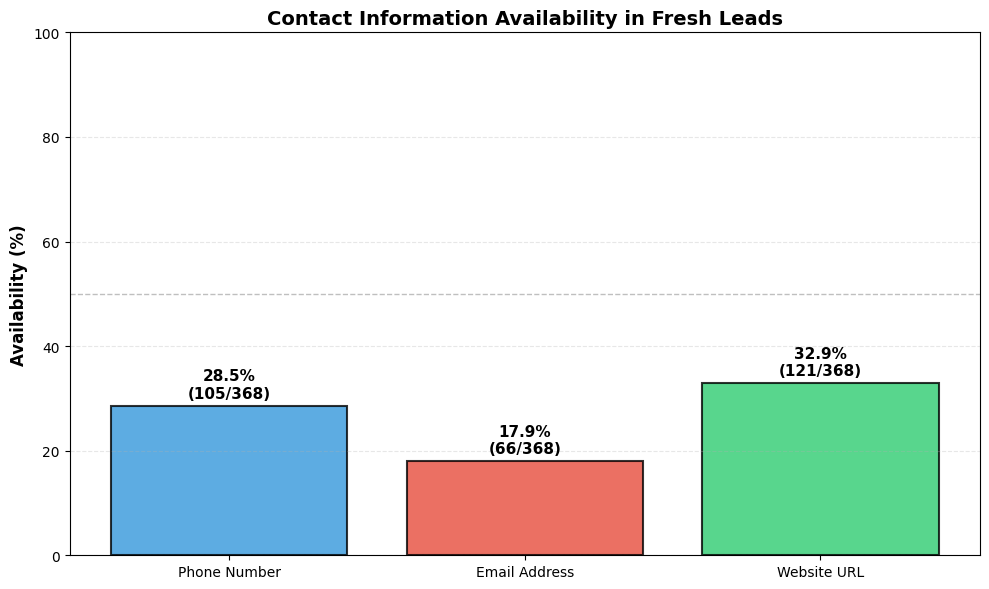


📊 Summary:
  Phone Numbers:  28.5% (105/368)
  Email Addresses: 17.9% (66/368)
  Website URLs:    32.9% (121/368)


In [109]:

# Calculate percentages and counts for each field
total_rows = len(Fresh_Leads_formatted)

phone_count = Fresh_Leads_formatted["PIC NAME 1 Contact Number"].notna().sum()
email_count = Fresh_Leads_formatted["PIC 1 email address"].notna().sum()
website_count = Fresh_Leads_formatted["Website URL"].notna().sum()

phone_pct = (phone_count / total_rows) * 100
email_pct = (email_count / total_rows) * 100
website_pct = (website_count / total_rows) * 100

# Data for plotting
fields = ['Phone Number', 'Email Address', 'Website URL']
percentages = [phone_pct, email_pct, website_pct]
counts = [phone_count, email_count, website_count]
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(fields, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add percentage and count labels on top of bars
for bar, pct, count in zip(bars, percentages, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{pct:.1f}%\n({count}/{total_rows})',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Customize the chart
plt.ylabel('Availability (%)', fontsize=12, fontweight='bold')
plt.title('Contact Information Availability in Fresh Leads', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add a horizontal line at 50%
plt.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary with counts
print(f"\n📊 Summary:")
print(f"  Phone Numbers:  {phone_pct:.1f}% ({phone_count}/{total_rows})")
print(f"  Email Addresses: {email_pct:.1f}% ({email_count}/{total_rows})")
print(f"  Website URLs:    {website_pct:.1f}% ({website_count}/{total_rows})")

In [46]:
# Fresh_Leads_formatted.to_excel("Fresh_Leads_formatted.xlsx", index=False)
